In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

from watermark_stable_diffusion import WatermarkStableDiffusion

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = WatermarkStableDiffusion.from_pretrained(model_id)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
empty_prompt_embedding = pipe.get_text_embedding("") # Assume we do not know the prompt that generated the image

In [ ]:
prompt = "Claude Shannon holding a red balloon"

seed = 229
torch.manual_seed(seed)

from typing import Dict, Tuple

def generate_watermark(latents: torch.Tensor) -> Tuple[float, torch.Tensor]:
    gamma = 0.0 # Set to 0 so this does NOTHING currently
    watermark_mask = torch.zeros_like(latents, dtype=torch.long)
    n_rows, n_cols = latents.shape[2:4]
    row_indices_c2 = (torch.arange(0, n_rows) - n_rows / 2) ** 2
    col_indices_c2 = (torch.arange(0, n_cols) - n_cols / 2) ** 2
    dist_grid = row_indices_c2.view(-1, 1) + col_indices_c2.view(1, -1) # Shape: (n_rows, n_cols)
    watermark_mask = (dist_grid >= 40 ** 2) * (dist_grid <= 45 ** 2)
    watermark_mask = watermark_mask.repeat(latents.shape[0], 4, 1, 1)
    return gamma, watermark_mask

def callback_watermark(pipe: WatermarkStableDiffusion, iter: int, t: int, tensor_inputs: Dict) -> Dict:
    if iter == 0:
        latents = tensor_inputs['latents']
        watermark, watermark_mask = generate_watermark(latents)
        latents[watermark_mask] += watermark
        print("Embedded watermark in initial latent")
        return {"latents" : latents}
    return {}
    
image = pipe(prompt,
            output_type='pil', 
            num_inference_steps=20,
            callback_on_step_end=callback_watermark, # type: ignore
            callback_on_step_end_tensor_inputs=['latents']).images[0] # type:ignore

  0%|          | 0/20 [00:00<?, ?it/s]

Embedded watermark in initial latent


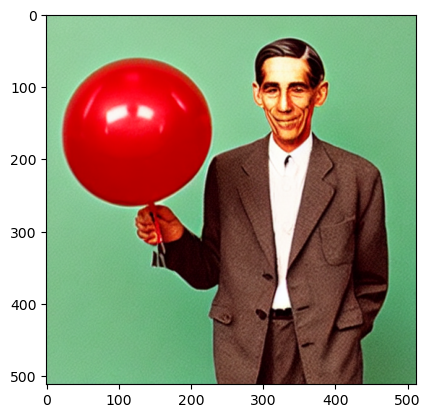

In [13]:
img_array = np.array(image)

plt.imshow(img_array)
plt.show()

In [14]:
def transform_image(image, target_size=512):
    """resize and output -1..1"""
    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0

image_tensor = transform_image(image).unsqueeze(0).cuda()
image_gen_latents = pipe.get_image_latents(image=image_tensor, sample=False)

In [15]:
tester_prompt = ''
text_embeddings = pipe.get_text_embedding(tester_prompt)

# Reverse the noise conditioned on an EMPTY prompt

image_noise = pipe(latents=image_gen_latents,
            prompt_embeds=text_embeddings,
            output_type='pil', 
            guidance_scale=1,
            num_inference_steps=50,
            forward_process=True).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

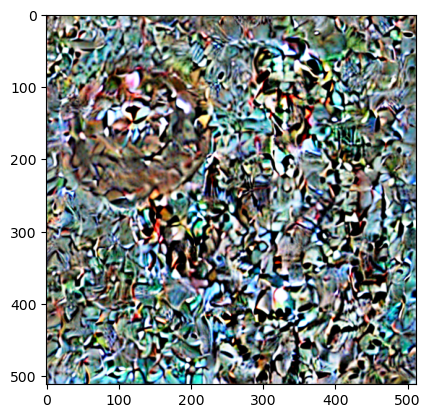

In [16]:
plt.imshow(image_noise)
plt.show()

In [17]:
noise_latents = pipe.get_last_latent()

image_noise_rev = pipe(prompt,
            latents=noise_latents,
            output_type='pil', 
            guidance_scale=1,
            num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

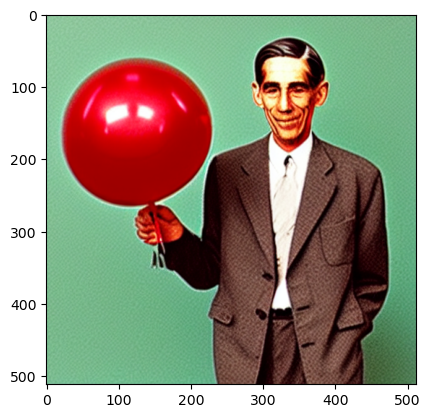

In [18]:
plt.imshow(image_noise_rev)
plt.show()